# Introduction 

Use this dataset of airline arrival information to predict how late flights
will be. A flight only counts as late if it is more than 30 minutes late.
1. The project should follow guideline as previous projects.
2. Apply models in Naïve Bayes, Logistic Regression, Decision
Tree, Random Forest, Gradient Boosting and SVM.
3. Apply PCA, SelectKBest and RFE for feature selections.
4. Using gridsearchCV to obtain best parameters for models.
5. Compare performances among models, write up analysis
why the model is good or bad in the algorithmic approach
(explain why the algorithm is good or bad for the dataset
structure, can you do something to improve the model?)
6. Include the conclusions.

In [106]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
import time 
import datetime
import seaborn as sns

# A quick look of datasets

In [107]:
# load the data
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
data = pd.read_csv("./2008_1mil.csv")
# Choose random 1 mil row
# data = data.sample(n=1000000)
# Export to csv file
# data.to_csv('./2008_1mil.csv')
data.head()

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,906837,2008,2,27,3,929.00,930,1043.00,1043,DL,1913,N912DE,74.00,73.00,46.00,0.00,-1.00,BOS,LGA,185,3.00,25.00,0,NaN,0,nan,nan,nan,nan,nan
1,6561950,2008,12,23,2,2304.00,2255,2358.00,2352,XE,2057,N16149,54.00,57.00,41.00,6.00,9.00,IAH,CRP,201,4.00,9.00,0,NaN,0,nan,nan,nan,nan,nan
2,1115097,2008,2,23,6,1754.00,1756,2012.00,2048,AS,3,N565AS,318.00,352.00,301.00,-36.00,-2.00,DCA,SEA,2329,7.00,10.00,0,NaN,0,nan,nan,nan,nan,nan
3,5196562,2008,9,22,1,948.00,925,1338.00,1310,MQ,3617,N524AE,170.00,165.00,144.00,28.00,23.00,DFW,ORF,1213,3.00,23.00,0,NaN,0,23.00,0.00,5.00,0.00,0.00
4,5656006,2008,10,1,3,1855.00,1900,1935.00,1955,WN,1549,N782SA,100.00,115.00,84.00,-20.00,-5.00,DEN,PHX,602,5.00,11.00,0,NaN,0,nan,nan,nan,nan,nan


In [108]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 30 columns):
Unnamed: 0           1000000 non-null int64
Year                 1000000 non-null int64
Month                1000000 non-null int64
DayofMonth           1000000 non-null int64
DayOfWeek            1000000 non-null int64
DepTime              980526 non-null float64
CRSDepTime           1000000 non-null int64
ArrTime              978313 non-null float64
CRSArrTime           1000000 non-null int64
UniqueCarrier        1000000 non-null object
FlightNum            1000000 non-null int64
TailNum              988099 non-null object
ActualElapsedTime    977872 non-null float64
CRSElapsedTime       999878 non-null float64
AirTime              977872 non-null float64
ArrDelay             977872 non-null float64
DepDelay             980526 non-null float64
Origin               1000000 non-null object
Dest                 1000000 non-null object
Distance             1000000 non-null int6

Outlier Detection and Removal

In [109]:
pd.options.display.float_format = "{:.2f}".format

In [110]:
data.describe()

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
count,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,980526.00,1000000.00,978313.00,1000000.00,1000000.00,977872.00,999878.00,977872.00,977872.00,980526.00,1000000.00,978313.00,980433.00,1000000.00,1000000.00,217955.00,217955.00,217955.00,217955.00,217955.00
mean,3501010.46,2008.00,6.37,15.72,3.93,1334.18,1326.56,1481.27,1495.38,2221.31,127.38,128.91,104.09,8.23,10.02,726.82,6.85,16.45,0.02,0.00,15.74,3.05,17.19,0.07,20.84
std,2022851.68,0.00,3.41,8.80,1.99,478.15,464.14,505.73,482.71,1962.64,70.31,69.51,67.57,38.62,35.51,563.05,4.90,11.29,0.14,0.05,40.43,19.31,32.02,1.80,39.44
min,0.00,2008.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,1.00,15.00,-140.00,0.00,-73.00,-67.00,11.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,1748530.50,2008.00,3.00,8.00,2.00,928.00,926.00,1107.00,1115.00,621.00,77.00,80.00,56.00,-10.00,-4.00,325.00,4.00,10.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,3498679.50,2008.00,6.00,16.00,4.00,1326.00,1320.00,1512.00,1518.00,1568.00,110.00,110.00,86.00,-2.00,-1.00,581.00,6.00,14.00,0.00,0.00,0.00,0.00,6.00,0.00,0.00
75%,5252372.25,2008.00,9.00,23.00,6.00,1728.00,1715.00,1909.00,1907.00,3511.00,157.00,159.00,132.00,12.00,8.00,954.00,8.00,19.00,0.00,0.00,16.00,0.00,21.00,0.00,26.00
max,7009723.00,2008.00,12.00,31.00,7.00,2400.00,2359.00,2400.00,2400.00,9741.00,790.00,660.00,664.00,1951.00,1952.00,4962.00,179.00,393.00,1.00,1.00,1951.00,1225.00,896.00,216.00,1303.00


Year is always 2008, we can drop Year column. 

In [111]:
data.drop(columns = 'Year', inplace=True)
data.head()

,Unnamed: 0,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,906837,2,27,3,929.00,930,1043.00,1043,DL,1913,N912DE,74.00,73.00,46.00,0.00,-1.00,BOS,LGA,185,3.00,25.00,0,NaN,0,nan,nan,nan,nan,nan
1,6561950,12,23,2,2304.00,2255,2358.00,2352,XE,2057,N16149,54.00,57.00,41.00,6.00,9.00,IAH,CRP,201,4.00,9.00,0,NaN,0,nan,nan,nan,nan,nan
2,1115097,2,23,6,1754.00,1756,2012.00,2048,AS,3,N565AS,318.00,352.00,301.00,-36.00,-2.00,DCA,SEA,2329,7.00,10.00,0,NaN,0,nan,nan,nan,nan,nan
3,5196562,9,22,1,948.00,925,1338.00,1310,MQ,3617,N524AE,170.00,165.00,144.00,28.00,23.00,DFW,ORF,1213,3.00,23.00,0,NaN,0,23.00,0.00,5.00,0.00,0.00
4,5656006,10,1,3,1855.00,1900,1935.00,1955,WN,1549,N782SA,100.00,115.00,84.00,-20.00,-5.00,DEN,PHX,602,5.00,11.00,0,NaN,0,nan,nan,nan,nan,nan


In [112]:
# Dữ liệu dạng object 
data.describe(include='O')

,UniqueCarrier,TailNum,Origin,Dest,CancellationCode
count,1000000,988099,1000000,1000000,19622
unique,20,5338,303,302,4
top,WN,N476HA,ATL,ATL,B
freq,171576,661,58810,58922,7924


Now the remained Numeric features are used IQR to check the outliers.

In [113]:
# dataNumeric = data.select_dtypes(include=np.number)
# # Drop FlightNum, it dont have outlier
# dataNumeric.drop(columns = 'FlightNum', inplace=True)

# # get quartile 1st and 3rd
# Q1, Q3 = dataNumeric.quantile(0.25), dataNumeric.quantile(0.75) 
# IQR = Q3 - Q1
# # Boundary
# cutOff = 3*IQR
# # Setup Boudnary
# lower, upper = Q1 - cutOff, Q3 + cutOff # identify Outliers
# for i in dataNumeric:
#     print(dataNumeric[i][(dataNumeric[i] < lower[i]) | (dataNumeric[i] > upper[i])].value_counts().sort_index())
#     print('Total Outliers for ' + i + ' is ' , dataNumeric[i][(dataNumeric[i] < lower[i]) | (dataNumeric[i] > upper[i])].value_counts().sum())
#     print('--------------------------------------------------------------\n')

Check and Fill Missing Value

In [114]:
# Number of missing values in each column
missingValueColumns = (data.isnull().sum())
# Find missing column in data
missingValueColumnsFrame = missingValueColumns[missingValueColumns > 0].to_frame()
# Rename to 0 to Count missingValueColumnsFrame=missingValueColumnsFrame.rename(columns={0:'Count'})
# add percentage column
missingValueColumnsFrame['Percentage'] = missingValueColumnsFrame/data.shape[0] * 100
missingValueColumnsFrame

,0,Percentage
DepTime,19474,1.95
ArrTime,21687,2.17
TailNum,11901,1.19
ActualElapsedTime,22128,2.21
CRSElapsedTime,122,0.01
AirTime,22128,2.21
ArrDelay,22128,2.21
DepDelay,19474,1.95
TaxiIn,21687,2.17
TaxiOut,19567,1.96


In [115]:
# data['CancellationCode'].fillna('0', inplace = True)
# data['CarrierDelay'].fillna(0, inplace = True)

# data['WeatherDelay'].fillna(0, inplace = True)
# data['NASDelay'].fillna(0, inplace = True)
# data['SecurityDelay'].fillna(0, inplace = True)
# data['LateAircraftDelay'].fillna(0, inplace = True)
data.drop(columns=['CancellationCode','CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay'], inplace= True)

In [116]:
data.dropna(inplace = True)
data.isnull().sum()

Unnamed: 0           0
Month                0
DayofMonth           0
DayOfWeek            0
DepTime              0
CRSDepTime           0
ArrTime              0
CRSArrTime           0
UniqueCarrier        0
FlightNum            0
TailNum              0
ActualElapsedTime    0
CRSElapsedTime       0
AirTime              0
ArrDelay             0
DepDelay             0
Origin               0
Dest                 0
Distance             0
TaxiIn               0
TaxiOut              0
Cancelled            0
Diverted             0
dtype: int64

In [117]:
def transformAttrition(value):
    if (value >= 30):
        return 1
    return 0
        
data['LateArr'] = data['ArrDelay'].apply(lambda x: transformAttrition(x))
data.head()

,Unnamed: 0,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted,LateArr
0,906837,2,27,3,929.00,930,1043.00,1043,DL,1913,N912DE,74.00,73.00,46.00,0.00,-1.00,BOS,LGA,185,3.00,25.00,0,0,0
1,6561950,12,23,2,2304.00,2255,2358.00,2352,XE,2057,N16149,54.00,57.00,41.00,6.00,9.00,IAH,CRP,201,4.00,9.00,0,0,0
2,1115097,2,23,6,1754.00,1756,2012.00,2048,AS,3,N565AS,318.00,352.00,301.00,-36.00,-2.00,DCA,SEA,2329,7.00,10.00,0,0,0
3,5196562,9,22,1,948.00,925,1338.00,1310,MQ,3617,N524AE,170.00,165.00,144.00,28.00,23.00,DFW,ORF,1213,3.00,23.00,0,0,0
4,5656006,10,1,3,1855.00,1900,1935.00,1955,WN,1549,N782SA,100.00,115.00,84.00,-20.00,-5.00,DEN,PHX,602,5.00,11.00,0,0,0


# Count late and no late

Text(0, 0.5, 'Frequency')

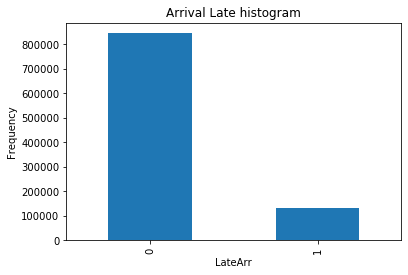

In [118]:
count_LateArr = pd.value_counts(data['LateArr'], sort = True).sort_index()
count_LateArr.plot(kind = 'bar')
plt.title("Arrival Late histogram")
plt.xlabel("LateArr")
plt.ylabel("Frequency")

In [119]:
# Data exploration 

In [120]:
# function that extract statistical parameters from a grouby objet:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
#_______________________________________________________________
# Creation of a dataframe with statitical infos on each airline:
global_stats = data['ArrDelay'].groupby(data['UniqueCarrier']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

,min,max,count,mean
UniqueCarrier,,,,
AQ,-53.00,242.00,1161.00,-2.94
HA,-71.00,855.00,8730.00,0.96
F9,-67.00,512.00,13637.00,6.44
AS,-60.00,586.00,21271.00,4.56
OH,-70.00,670.00,27370.00,11.94
B6,-73.00,591.00,27479.00,11.08
YV,-71.00,518.00,35038.00,11.64
9E,-59.00,1094.00,36182.00,4.41
FL,-69.00,1175.00,36770.00,9.18


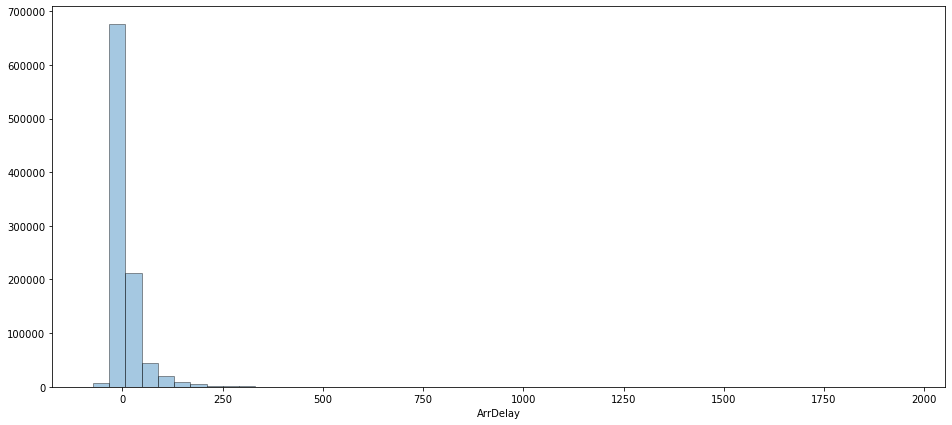

In [121]:
plt.figure(figsize=(16,7))
#plt.xlim(-100,100)
sns.distplot(data['ArrDelay'], kde = False,hist_kws=dict(edgecolor="k"))


In [122]:
# numerical = data.select_dtypes(include = [np.number])

# %config InlineBackend.figure_format = 'png'
# #Plot numerical data against ArrDelay
# fig, axes = plt.subplots(8, 3, figsize=(12, 24))

# for idx, feat in enumerate(numerical.columns.difference(['ArrDelay'])):
#     ax = axes[int(idx / 3), idx%3]
#     sns.scatterplot(x=feat, y='ArrDelay', data=numerical, ax=ax);
#     ax.set_xlabel(feat)
#     ax.set_ylabel('ArrDelay')
    
# fig.tight_layout();

Text(0.5, 1, 'Variable Correlation')

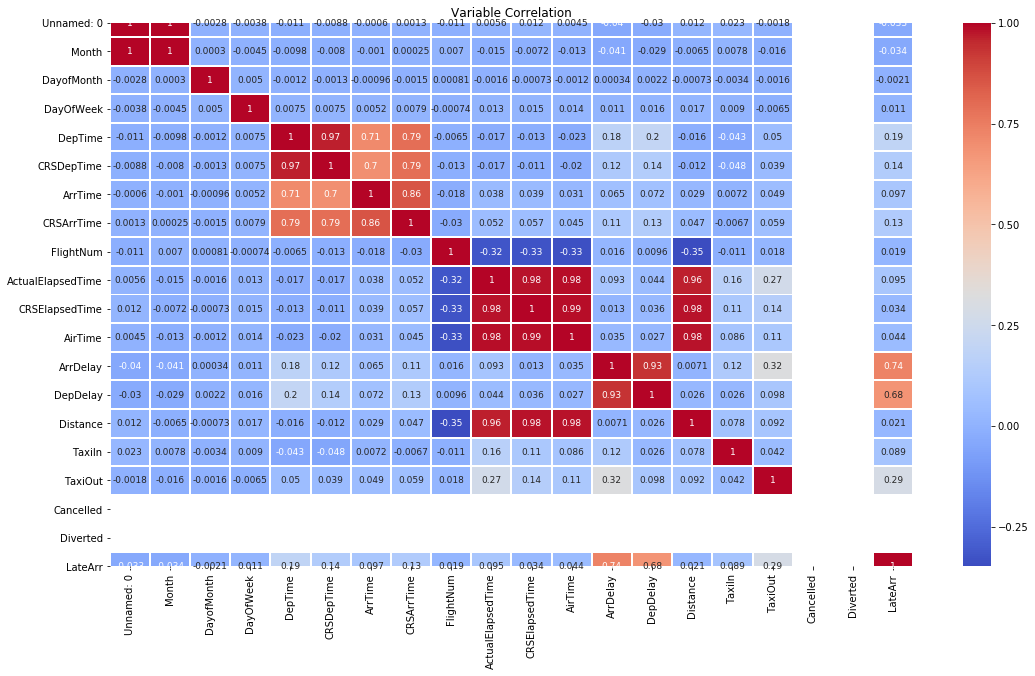

In [123]:
plt.figure(figsize=(18,10))
sns.heatmap(data.corr(),cmap = 'coolwarm',linewidth = 1,annot= True, annot_kws={"size": 9})
plt.title('Variable Correlation')

Base on above Correlation, I will drop columns that have very high Correlation

In [124]:
data.drop(columns=['CRSDepTime','CRSArrTime','CRSElapsedTime','ActualElapsedTime'], inplace= True)
data.head()

,Unnamed: 0,Month,DayofMonth,DayOfWeek,DepTime,ArrTime,UniqueCarrier,FlightNum,TailNum,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted,LateArr
0,906837,2,27,3,929.00,1043.00,DL,1913,N912DE,46.00,0.00,-1.00,BOS,LGA,185,3.00,25.00,0,0,0
1,6561950,12,23,2,2304.00,2358.00,XE,2057,N16149,41.00,6.00,9.00,IAH,CRP,201,4.00,9.00,0,0,0
2,1115097,2,23,6,1754.00,2012.00,AS,3,N565AS,301.00,-36.00,-2.00,DCA,SEA,2329,7.00,10.00,0,0,0
3,5196562,9,22,1,948.00,1338.00,MQ,3617,N524AE,144.00,28.00,23.00,DFW,ORF,1213,3.00,23.00,0,0,0
4,5656006,10,1,3,1855.00,1935.00,WN,1549,N782SA,84.00,-20.00,-5.00,DEN,PHX,602,5.00,11.00,0,0,0


In [125]:
dataLateArr = data[ data['LateArr']==1]
dataNotLateArr = data[ data['LateArr']==0]
dataLateArr.head()

,Unnamed: 0,Month,DayofMonth,DayOfWeek,DepTime,ArrTime,UniqueCarrier,FlightNum,TailNum,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted,LateArr
5,3598208,6,15,7,1828.00,2306.00,DL,137,N648DL,332.00,70.00,-2.00,JFK,LAX,2475,15.00,111.00,0,0,1
7,4993789,9,30,2,1430.00,1638.00,OH,6756,N962CA,83.00,47.00,30.00,LGA,GSO,461,5.00,40.00,0,0,1
18,5577161,10,29,3,1037.00,1144.00,OO,6601,N715SK,112.00,56.00,73.00,MSN,DEN,826,8.00,7.00,0,0,1
22,326448,1,31,4,1813.00,2159.00,EV,4270,N885AS,119.00,76.00,38.00,OKC,ATL,761,20.00,27.00,0,0,1
31,6497780,12,13,6,1038.00,1129.00,WN,173,N639SW,36.00,39.00,38.00,DAL,OKC,181,4.00,11.00,0,0,1


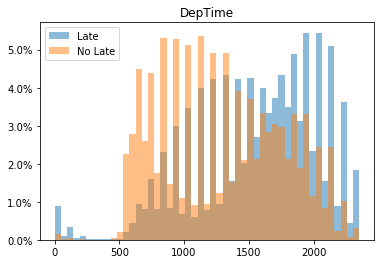

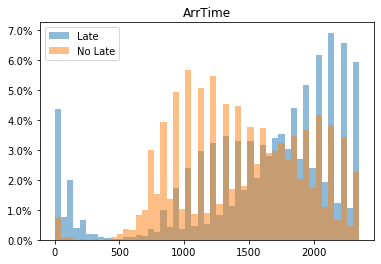

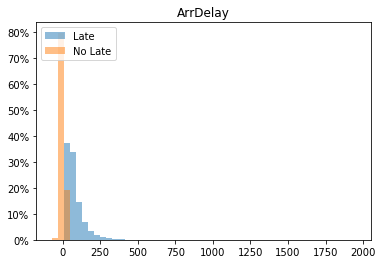

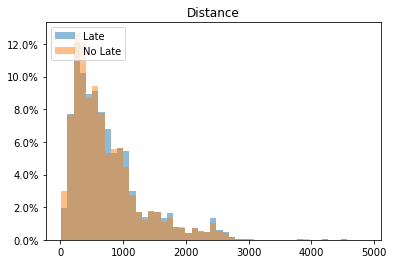

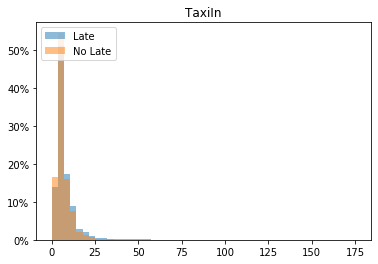

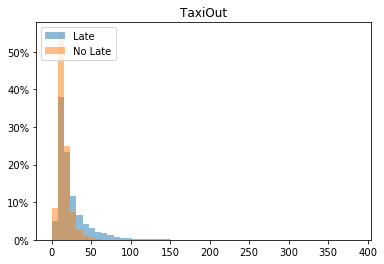

In [126]:
from matplotlib.ticker import PercentFormatter
columns = ['DepTime', 'ArrTime', 'ArrDelay', 'Distance', 'TaxiIn', 'TaxiOut']
for column in columns:
    bins = np.arange(start=data[column].min(), stop=data[column].max(), step=(data[column].max()-data[column].min())/50)
    plt.hist(dataLateArr[column], alpha=0.5, label='Late', bins=bins, weights = np.ones(len(dataLateArr[column])) / len(dataLateArr[column]))
    plt.hist(dataNotLateArr[column], alpha=0.5, label='No Late', bins=bins, weights = np.ones(len(dataNotLateArr[column])) / len(dataNotLateArr[column]))
    plt.legend(loc='upper left')
    plt.title(column)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.show()

Base on above graphs, there are nearly equal in TaxiIn, Distance feature. We will select DepTime, ArrTime, TaxiOut for classification.

Category data

In [127]:
# Dữ liệu dạng object 
data[[ 'Month','DayofMonth', 'DayOfWeek', 'FlightNum', 'Cancelled', 'Diverted']]=data[['Month','DayofMonth', 'DayOfWeek', 'FlightNum', 'Cancelled', 'Diverted']].astype('category')

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 977872 entries, 0 to 999999
Data columns (total 20 columns):
Unnamed: 0       977872 non-null int64
Month            977872 non-null category
DayofMonth       977872 non-null category
DayOfWeek        977872 non-null category
DepTime          977872 non-null float64
ArrTime          977872 non-null float64
UniqueCarrier    977872 non-null object
FlightNum        977872 non-null category
TailNum          977872 non-null object
AirTime          977872 non-null float64
ArrDelay         977872 non-null float64
DepDelay         977872 non-null float64
Origin           977872 non-null object
Dest             977872 non-null object
Distance         977872 non-null int64
TaxiIn           977872 non-null float64
TaxiOut          977872 non-null float64
Cancelled        977872 non-null category
Diverted         977872 non-null category
LateArr          977872 non-null int64
dtypes: category(6), float64(7), int64(3), object(4)
memory usage: 158.8+

In [128]:
def CategoricalPlot(target,feature,data,label=None,legend=None,title=None,percentagePrint=False): 
    '''target: Name of target (str)
    feature: Name of feature (str) data: dataFrame
    lable: lables for (x,y) legend: list for two line title: title of line'''
    FeatureCount = data.groupby(target)[feature].value_counts().sort_index() 
    FeatureCountNo = FeatureCount[0]/data[target].value_counts()[0]*100
    FeatureCountYes = FeatureCount[1]/data[target].value_counts()[1]*100
    if(percentagePrint):
        print('Non-delay: ',FeatureCountNo , '%' ) 
        print('Delay: ',FeatureCountYes , '%' )
    plt.figure(figsize=(8,6)) # figure size 
    plt.plot(FeatureCountNo,  label=legend[0]) 
    plt.plot(FeatureCountYes,  label=legend[1]) 
    plt.xlabel(label[0],fontsize=10)
    plt.xticks(fontsize=10) ## Major tick lable size 
    plt.ylabel('Percentage(%)',fontsize=10) 
    plt.yticks(fontsize=10) ## Major tick lable size 
    plt.title(title + ' in '+ target,fontsize=10) 
    plt.legend(loc='upper right',fontsize=10)
    plt.show()

In [129]:
data.drop(columns=['TailNum','FlightNum'], inplace= True)

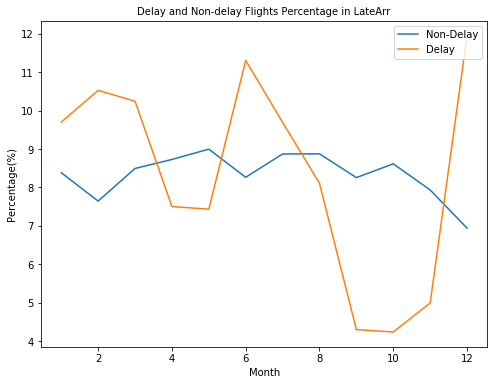

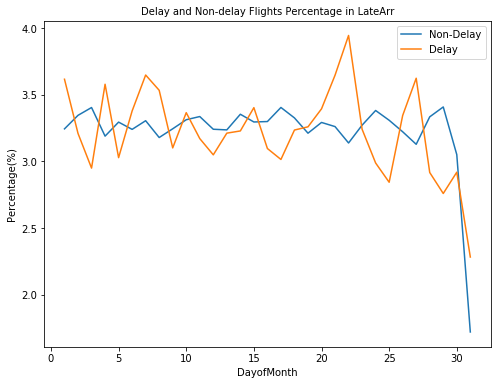

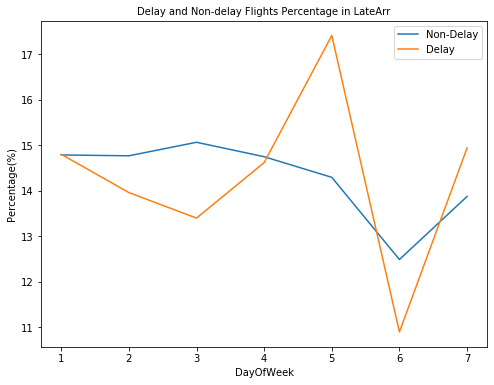

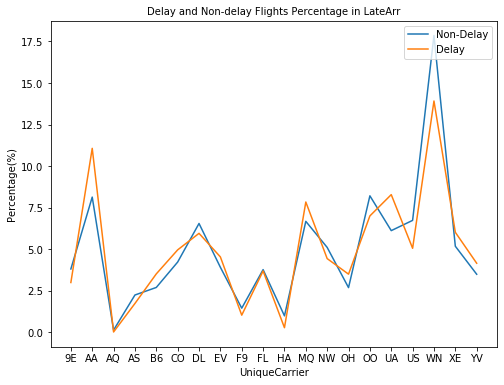

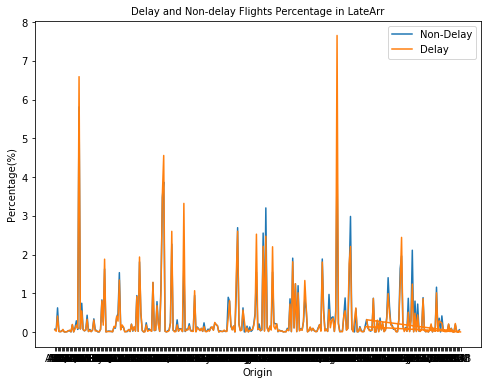

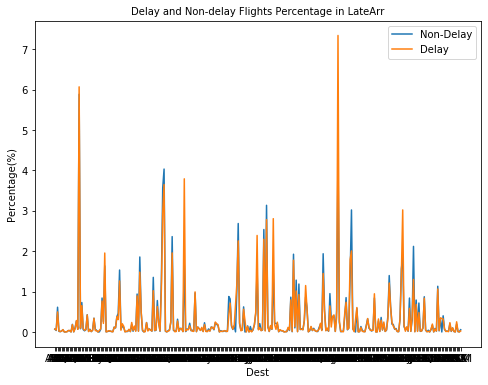

In [130]:
CategoricalPlot(target='LateArr',feature='Month',data=data,label = ['Month'], legend=['Non-Delay','Delay'],title='Delay and Non-delay Flights Percentage')
CategoricalPlot(target='LateArr',feature='DayofMonth',data=data,label = ['DayofMonth'], legend=['Non-Delay','Delay'],title='Delay and Non-delay Flights Percentage')
CategoricalPlot(target='LateArr',feature='DayOfWeek',data=data,label = ['DayOfWeek'], legend=['Non-Delay','Delay'],title='Delay and Non-delay Flights Percentage')
CategoricalPlot(target='LateArr',feature='UniqueCarrier',data=data,label = ['UniqueCarrier'], legend=['Non-Delay','Delay'],title='Delay and Non-delay Flights Percentage')
CategoricalPlot(target='LateArr',feature='Origin',data=data,label = ['Origin'], legend=['Non-Delay','Delay'],title='Delay and Non-delay Flights Percentage')
CategoricalPlot(target='LateArr',feature='Dest',data=data,label = ['Dest'], legend=['Non-Delay','Delay'],title='Delay and Non-delay Flights Percentage')

Base on above graphs, I will choose Month, DayofMonth, DayofWeek for classification. 

In [ ]:

categorical = data.select_dtypes(exclude = [np.number]) 
numerical = data.select_dtypes(include = [np.number])
print(categorical.columns) 
categorical_OneHot = pd.DataFrame() 
for i in categorical:
    categorical_OneHot = pd.concat( [categorical_OneHot, pd.get_dummies(categorical[i], drop_first= True)], axis=1)
categorical_OneHot.head()

In [ ]:
data_withOneHot = pd.DataFrame()
data_withOneHot = numerical.copy()
data_withOneHot = pd.concat([data_withOneHot,categorical_OneHot],axis=1) 
data = data_withOneHot
data.head()


In [ ]:
data.shape

Nhìn vào phân phối trên, các biến có ảnh hưởng đến ArrDelay là DepTime, ArrTime, ArrDelay, TaxiOut 

# Apply Model 

# Naive Bayes 


In [ ]:
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split


# X = data[['DepTime', 'ArrTime', 'ArrDelay', 'TaxiOut']]
# Y = data['LateArr']
X = data.copy()
X.drop(columns=['LateArr'], inplace= True)
Y = data['LateArr']

# Train, test, split
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = .20, random_state= 0)

clf = GaussianNB()
clf.fit(X_train, y_train)
GaussianNB(priors=None, var_smoothing=1e-09)


y_pred = clf.predict(X_test)
print(clf.score(X_test, y_test))

## Metrics

- Accuracy = (TP+TN)/total
- Precision = TP/(TP+FP)
- Recall = TP/(TP+FN)

accuracy_score: Tỉ lệ giữa số điểm được dự đoán đúng / Tổng số điểm tập test 

Precision: được định nghĩa là tỉ lệ số điểm true positive trong số những điểm được phân loại là positive

Recall được định nghĩa là tỉ lệ số điểm true positive trong số những điểm thực sự là positive

https://machinelearningcoban.com/2017/08/31/evaluation/#-accuracy

In [ ]:
naive_bayes_recall = metrics.recall_score(y_test, y_pred)
print('accuracy score',  metrics.accuracy_score(y_test, y_pred))
print('Precision score', metrics.precision_score(y_test, y_pred))
print('recall score', naive_bayes_recall)

In [ ]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:


# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

# Logistic Regression 

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
lg_score = model.score(X_test, y_test)
print(lg_score)

In [ ]:
print('accuracy score',  metrics.accuracy_score(y_test, y_pred))
print('Precision score', metrics.precision_score(y_test, y_pred))
print('recall score', metrics.recall_score(y_test, y_pred))

In [ ]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=10, max_depth=2,
                             random_state=0)
rf_model.fit(X_train, y_train)
rf_y_pred = rf_model.predict(X_test)

print('accuracy score',  metrics.accuracy_score(y_test, rf_y_pred))
print('Precision score', metrics.precision_score(y_test, rf_y_pred))
print('recall score', metrics.recall_score(y_test, rf_y_pred))

In [ ]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test,rf_y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

# Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)
gb_y_pred = gb_model.predict(X_test)

print('accuracy score',  metrics.accuracy_score(y_test, rf_y_pred))
print('Precision score', metrics.precision_score(y_test, rf_y_pred))
print('recall score', metrics.recall_score(y_test, rf_y_pred))

In [ ]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test,rf_y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

Mean accuracy is 0.99, higher than Naive Bayes

# Apply PCA

In [ ]:
from sklearn import preprocessing

# Split
X = data.copy()
X.drop(columns=['LateArr'], inplace= True)
Y = data['LateArr']

#Standardize the data before feeding it to PCA algorithm
scaler = preprocessing.StandardScaler()
scaler.fit(X )

X = scaler.transform(X)

#Use PCA algorithm to reduce the number of features to speed up training 
pca = PCA(n_components=17)
pca.fit(X)

# Use PCA to transform data 
X  = pca.transform(X)

In [ ]:
# Train, test, split
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = .20, random_state= 0)




## Naive bayes

In [ ]:
# Naive bayes
clf = GaussianNB()
clf.fit(X_train, y_train)
GaussianNB(priors=None, var_smoothing=1e-09)
y_pred = clf.predict(X_test)
print('accuracy score',  metrics.accuracy_score(y_test, y_pred))
print('Precision score', metrics.precision_score(y_test, y_pred))
print('recall score', naive_bayes_recall)

## Logistic Regression

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('accuracy score',  metrics.accuracy_score(y_test, y_pred))
print('Precision score', metrics.precision_score(y_test, y_pred))
print('recall score', metrics.recall_score(y_test, y_pred))

In [ ]:
cnf_matrix = metrics.confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

## Random Forest

In [ ]:
rf_model = RandomForestClassifier(n_estimators=10, max_depth=2,
                             random_state=0)
rf_model.fit(X_train, y_train)
rf_y_pred = rf_model.predict(X_test)

print('accuracy score',  metrics.accuracy_score(y_test, rf_y_pred))
print('Precision score', metrics.precision_score(y_test, rf_y_pred))
print('recall score', metrics.recall_score(y_test, rf_y_pred))

In [ ]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test,rf_y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

## Gradient Boosting

In [ ]:
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)
gb_y_pred = gb_model.predict(X_test)

print('accuracy score',  metrics.accuracy_score(y_test, rf_y_pred))
print('Precision score', metrics.precision_score(y_test, rf_y_pred))
print('recall score', metrics.recall_score(y_test, rf_y_pred))

In [ ]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test,rf_y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

## Coclusion for apply PCA

Apply PCA not give us better result. Base on analyze above results are worst than does not apply PCA. 

Reason: Apply PCA will lost some data. It good for apply PCA in Linear Regression because we can avoid correlation. But in classification problem, PCA does not help.

# Apply SelectKBest

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# Split
X = data.copy()
X.drop(columns=['LateArr'], inplace= True)
Y = data['LateArr']
#Standardize the data before feeding it to PCA algorithm
scaler = preprocessing.StandardScaler()
scaler.fit(X )
X = scaler.transform(X)

X = SelectKBest(f_classif, k=20).fit_transform(X, Y)
X.shape

## Naive bayes

In [ ]:
# Naive bayes
clf = GaussianNB()
clf.fit(X_train, y_train)
GaussianNB(priors=None, var_smoothing=1e-09)
y_pred = clf.predict(X_test)
print('accuracy score',  metrics.accuracy_score(y_test, y_pred))
print('Precision score', metrics.precision_score(y_test, y_pred))
print('recall score', naive_bayes_recall)

In [ ]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test,rf_y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

## Logistic Regression

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('accuracy score',  metrics.accuracy_score(y_test, y_pred))
print('Precision score', metrics.precision_score(y_test, y_pred))
print('recall score', metrics.recall_score(y_test, y_pred))

In [ ]:
cnf_matrix = metrics.confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

In [ ]:
## Random Forest

In [ ]:
rf_model = RandomForestClassifier(n_estimators=10, max_depth=2,
                             random_state=0)
rf_model.fit(X_train, y_train)
rf_y_pred = rf_model.predict(X_test)

print('accuracy score',  metrics.accuracy_score(y_test, rf_y_pred))
print('Precision score', metrics.precision_score(y_test, rf_y_pred))
print('recall score', metrics.recall_score(y_test, rf_y_pred))

In [ ]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test,rf_y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

## Gradient Boosting

In [ ]:
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)
gb_y_pred = gb_model.predict(X_test)

print('accuracy score',  metrics.accuracy_score(y_test, rf_y_pred))
print('Precision score', metrics.precision_score(y_test, rf_y_pred))
print('recall score', metrics.recall_score(y_test, rf_y_pred))

In [ ]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test,rf_y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

## Conclusion for SelectKBest

Apply SelectKBest not give us better result. Base on analyze above results are worst than does not apply SelectKBest. 


# Using gridsearchCV to obtain best parameters for models.

In [ ]:
## Naive bayes

In [ ]:
an

# Conclusion

In [ ]:
Logistic Regression give the best result 

# Reference

## Imbalance: 
dữ liệu ko cân bằng, sl số 1 và 0 là rất khác nhau ( giả sử 0 rất nhiều 90%)
Model mình ko làm gì cả và phán tất cả là 0 

P = 0.9
R = 0 (recall)
=> F(0) = 0 ko học dc gì
### Cách 1: Tìm thuật toán robust with imbalance: decision tree , naive bayes, knn 

### Cách 2: Điều chỉnh threshold
Logistic regression:
>0.5 coi như 1, < 0.5 coi như 0 
predict_proba() -> xác suất là số 1, 0

Điều chỉnh threshold của model 0.3

### Cách 3: Điều chỉnh cost function 
cost = y*log(1-y) + (1-y)log(1-y)
ylog(1-y) : là số 1
(1-y)log(1-y) : là số 0
Để thay đổi cost mình nhân thêm tham số alpha
cost = alpha*y*log(1-y) + (1-alpha)(1-y)log(1-y)
Tức là nếu dự đoán sai số 1, thì cost lớn hơn nhiều so với dự đoán sai số 0


### Cách 4: resampling
Chọn radom 10 làn trong data số 0
- up sample 
- down sample 

Logistic regression

Logistic regression: số thực 
Naive bayes, decision tree: category 


Gaussian
Multinomial: category nhiều hơn 2
Complement
Bernoulli: phân loại 0,1
        